# Estimando o $ R_t $ do COVID-19 em tempo real (para o Brasil)
Original study by Kevin Systrom - April 17  
Estudo adaptado do repositório [k-sys](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb)  
Por Fernando Serboncini em (20 de Abril de 2020)[repositório](https://github.com/fserb/covid19-rt)

Em qualquer epidemia, $ R_t $ é a medida conhecida como número de reprodução efetivo. É o número de pessoas que são infectadas por pessoa infecciosa no momento $ t $. A versão mais conhecida desse número é o número de reprodução básico: $ R_0 $ quando $ t = 0 $. No entanto, $ R_0 $ é uma medida única que não se adapta a mudanças de comportamento e restrições.

À medida que uma pandemia evolui, o aumento de restrições (ou possível liberação de restrições) altera $ R_t $. Conhecer o atual $ R_t $ é essencial. Quando $ R \ gg1 $, a pandemia se espalhará por grande parte da população. Se $ R_t <1 $, a pandemia diminuirá rapidamente antes de ter a chance de infectar muitas pessoas. Quanto menor o $ R_t $: mais administrável é a situação. Em geral, qualquer $ R_t <1 $ significa que as coisas estão sob controle.

O valor de $ R_t $ nos ajuda de duas maneiras. (1) Isso nos ajuda a entender a eficácia de nossas medidas para controlar um surto e (2) fornece informações vitais sobre se devemos aumentar ou reduzir as restrições com base em nossos objetivos concorrentes de prosperidade econômica e segurança humana. [Epidemiologistas respeitados argumentam] (https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) que rastrear $ R_t $ é a única maneira de administrar essa crise .

Ainda hoje, ainda não usamos $ R_t $ dessa maneira. De fato, a única medida em tempo real que eu vi foi para [Hong Kong] (https://covid19.sph.hku.hk/dashboard). Mais importante, não é útil entender $ R_t $ em nível nacional. Em vez disso, para gerenciar essa crise de maneira eficaz, precisamos de uma granularidade local (estado, município e / ou cidade) de $ R_t $.

O que se segue é uma solução para esse problema no nível do Estado dos EUA. É uma versão modificada de uma solução criada por [Bettencourt & Ribeiro 2008] (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) para estimar $ R_t $ em tempo real usando um Abordagem bayesiana. Embora este artigo calcule um valor estático de R $, aqui apresentamos um modelo de processo com ruído gaussiano para estimar um $ R_t $ variável no tempo.

Se você tiver perguntas, comentários ou melhorias, não hesite em entrar em contato: [hello@systrom.com] (mailto: hello@systrom.com). E se não estiver totalmente claro, não sou epidemiologista. Ao mesmo tempo, dados são dados e estatísticas são estatísticas, e isso é baseado no trabalho de epidemiologistas conhecidos, para que você possa calibrar suas crenças conforme desejar. Enquanto isso, espero que você possa aprender algo novo como eu, lendo este exemplo. Sinta-se à vontade para levar esse trabalho e aplicá-lo em outros lugares - internacionalmente ou em condados nos Estados Unidos.

Além disso, um enorme agradecimento a [Frank Dellaert] (http://www.twitter.com/fdellaert/), que sugeriu a adição do processo e a [Adam Lerer] (http://www.twitter.com/adamlerer/ ) que implementou as alterações. Não apenas aprendi algo novo, como também tornou o modelo muito mais responsivo.

In [25]:
import pandas as pd
import numpy as np
import os
import wget

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib as mpl
mpl.rcParams['figure.max_open_warning'] = 0

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output

FILTERED_REGION_CODES = ["PB", "TO"]

%config InlineBackend.figure_format = 'retina'

## Abordagem de Bettencourt & Ribeiro

Todos os dias, aprendemos quantas mais pessoas têm o COVID-19. Essa nova contagem de casos nos dá uma pista sobre o valor atual de $ R_t $. Também achamos que o valor de $ R_t $ hoje está relacionado ao valor de $ R_ {t-1} $ (valor de ontem) e a todo valor anterior de $ R_ {t-m} $ nesse caso.

Com essas idéias, os autores usam a [regra de Bayes] (https://en.wikipedia.org/wiki/Bayes%27_theorem) para atualizar suas crenças sobre o valor real de $ R_t $ com base em quantos novos casos foram relatados cada dia.

Este é o Teorema de Bayes, como usaremos:

$$ P (R_t | k) = \ frac {P (k | R_t) \ cdot P (R_t)} {P (k)} $$

Isso diz que, após ver novos casos de $ k $, acreditamos que a distribuição de $ R_t $ seja igual a:

- A __likelihood__ de ver $ k $ novos casos dados $ R_t $ vezes ...
- As crenças __prior__ do valor de $ P (R_t) $ sem os dados ...
- dividido pela probabilidade de ver tantos casos em geral.

Isto é para um único dia. Para torná-lo iterativo: todos os dias que passam, usamos $ P (R_ {t-1}) $ anterior para estimar $ P (R_t) $ anterior. Vamos assumir que a distribuição de $ R_t $ seja um gaussiano centrado em torno de $ R_ {t-1} $, então $ P (R_t | R_ {t-1}) = \ mathcal {N} (R_ {t-1} , \ sigma) $, onde $ \ sigma $ é um hiperparâmetro (veja abaixo como estimamos $ \ sigma $). Então, no primeiro dia:

$$ P (R_1 | k_1) \ propto P (R_1) \ cdot \ mathcal {L} (R_1 | k_1) $$

No segundo dia:

$$ P (R_2 | k_1, k_2) \ propto P (R_2) \ cdot \ mathcal {L} (R_2 | k_2) = \ sum_ {R_1} {P (R_1 | k_1) \ cdot P (R_2 | R_1) \ cdot \ mathcal {L} (R_2 | k_2)} $$

etc.

### Escolhendo uma função de verossimilhança $ P \ left (k_t | R_t \ right) $

Uma função de função de probabilidade indica a probabilidade de vermos $ k $ novos casos, considerando um valor de $ R_t $.

Sempre que você precisar modelar 'chegadas' durante um período de tempo, os estatísticos gostam de usar a [Distribuição de Poisson] (https://en.wikipedia.org/wiki/Poisson_distribution). Dada uma taxa média de chegada de $ \ lambda $ casos novos por dia, a probabilidade de ver $ k $ casos novos é distribuída de acordo com a distribuição de Poisson:

$$ P (k | \ lambda) = \ frac {\ lambda ^ k e ^ {- \ lambda}} {k!} $$

In [2]:
# Column vector of k
k = np.arange(0, 70)[:, None]

# Different values of Lambda
lambdas = [10, 20, 30, 40]

# Evaluated the Probability Mass Function (remember: poisson is discrete)
y = sps.poisson.pmf(k, lambdas)

# Show the resulting shape
print(y.shape)

(70, 4)


> __Nota__: esta era uma expressão concisa, o que a torna complicada. Tudo o que fiz foi transformar $ k $ em uma coluna. Ao fornecer uma coluna para $ k $ e uma 'linha' para o lambda, ele avaliará o pmf sobre os dois e produzirá uma matriz que possui $ k $ linhas e colunas lambda. Esta é uma maneira eficiente de produzir muitas distribuições de uma só vez, e você verá novamente o item abaixo__!

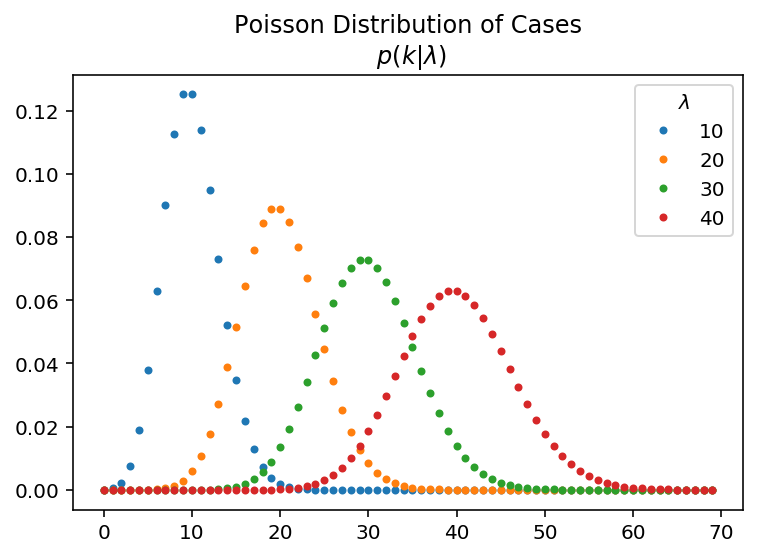

In [3]:
fig, ax = plt.subplots()

ax.set(title='Poisson Distribution of Cases\n $p(k|\lambda)$')

plt.plot(k, y,
         marker='o',
         markersize=3,
         lw=0)

plt.legend(title="$\lambda$", labels=lambdas);

A distribuição de Poisson diz que, se você acha que terá $ \ lambda $ casos por dia, provavelmente terá muitas variações, mais ou menos, com base no acaso.

Mas, no nosso caso, sabemos que houve casos de $ k $ e precisamos saber qual o valor de $ \ lambda $ é mais provável. Para fazer isso, fixamos $ k $ no local enquanto variamos $ \ lambda $. __Isso é chamado de função de probabilidade .__

Por exemplo, imagine que observamos $ k = 20 $ novos casos e queremos saber qual a probabilidade de cada $ \ lambda $:

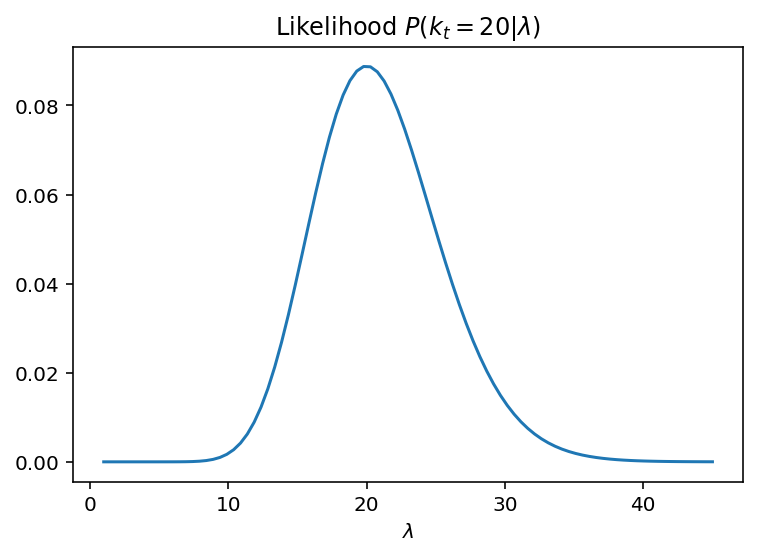

In [4]:
k = 20

lam = np.linspace(1, 45, 90)

likelihood = pd.Series(data=sps.poisson.pmf(k, lam),
                       index=pd.Index(lam, name='$\lambda$'),
                       name='lambda')

likelihood.plot(title=r'Likelihood $P\left(k_t=20|\lambda\right)$');

Isso diz que, se observarmos 20 casos, o valor mais provável de $ \ lambda $ é (sem surpresa) 20. Mas não temos certeza: é possível que o lambda tenha 21 ou 17 anos e tenha visto 20 novos casos por acaso. Também diz que é improvável que $ \ lambda $ tenha 40 anos e vimos 20.

Ótimo. Temos $ P \ left (\ lambda_t | k_t \ right) $, que é parametrizado por $ \ lambda $, mas estávamos procurando por $ P \ left (k_t | R_t \ right) $, que é parametrizado por $ R_t $. Precisamos conhecer a relação entre $ \ lambda $ e $ R_t $

### Conectando $ \ lambda $ e $ R_t $

__ A chave principal para fazer esse trabalho é perceber que há uma conexão entre $ R_t $ e $ \ lambda $ __. [A derivação] (https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185) está além do escopo deste caderno, mas aqui está:

$$ \ lambda = k_ {t-1} e ^ {\ gama (R_t-1)} $$

onde $ \ gamma $ é o inverso do intervalo serial ([cerca de 7 dias para COVID19] (https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article)). Como sabemos que cada novo caso conta no dia anterior, agora podemos reformular a função de probabilidade como um Poisson parametrizado, fixando $ k $ e variando $ R_t $.

$$ \ lambda = k_ {t-1} e ^ {\ gama (R_t-1)} $$

$$ P \ esquerda (k | R_t \ direita) = \ frac {\ lambda ^ k e ^ {- \ lambda}} {k!} $$

### Avaliação da função de verossimilhança

Para continuar nosso exemplo, vamos imaginar que uma amostra de um novo caso conte $ k $. Qual é a probabilidade de valores diferentes de $ R_t $ em cada um desses dias?

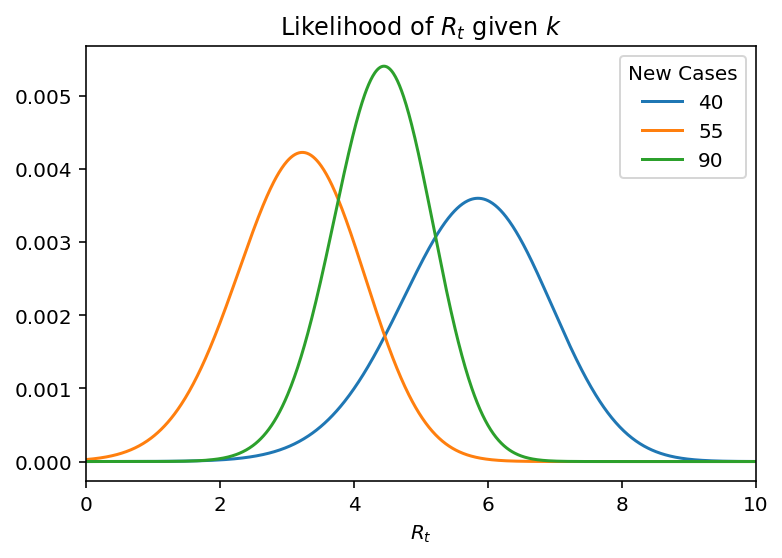

In [5]:
k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
# CHANGE: using 19 for deaths instead of 7 for cases
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

# Plot it
ax = pd.DataFrame(
    data = likelihood_r_t,
    index = r_t_range
).plot(
    title='Likelihood of $R_t$ given $k$',
    xlim=(0,10)
)

ax.legend(labels=k[1:], title='New Cases')
ax.set_xlabel('$R_t$');

Você pode ver que todos os dias temos uma estimativa independente de $ R_t $. O objetivo é combinar as informações que temos sobre os dias anteriores com o dia atual. Para fazer isso, usamos o teorema de Bayes.

### Executando a atualização bayesiana

Para executar a atualização bayesiana, precisamos multiplicar a probabilidade pelo anterior (que é apenas a probabilidade do dia anterior sem a nossa atualização gaussiana) para obter as posteriores. Vamos fazer isso usando o produto cumulativo de cada dia sucessivo:

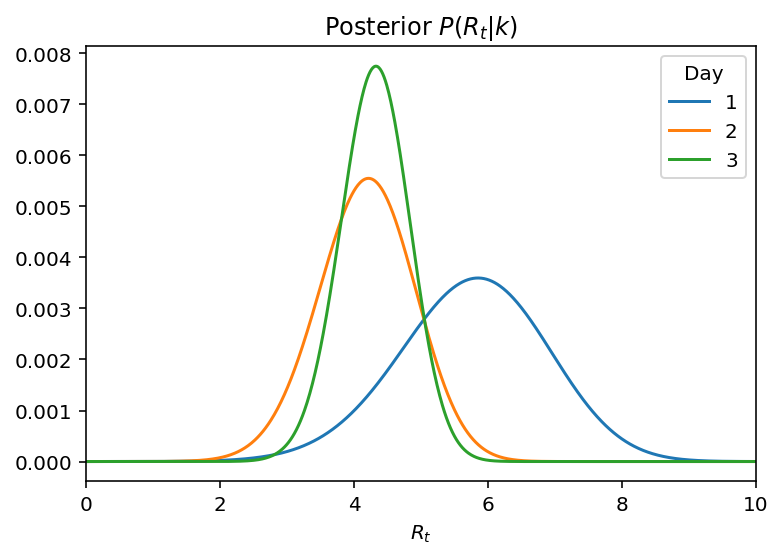

In [6]:
posteriors = likelihood_r_t.cumprod(axis=1)
posteriors = posteriors / np.sum(posteriors, axis=0)

columns = pd.Index(range(1, posteriors.shape[1]+1), name='Day')
posteriors = pd.DataFrame(
    data = posteriors,
    index = r_t_range,
    columns = columns)

ax = posteriors.plot(
    title='Posterior $P(R_t|k)$',
    xlim=(0,10)
)
ax.legend(title='Day')
ax.set_xlabel('$R_t$');

Observe como no dia 1, nossa posterior corresponde à probabilidade de dia 1 de cima? Isso porque não temos informações além desse dia. No entanto, quando atualizamos o anterior usando as informações do dia 2, você pode ver que a curva se moveu para a esquerda, mas não tão esquerda quanto a probabilidade do dia 2 de cima. Isso ocorre porque a atualização bayesiana usa informações dos dois dias e calcula a média efetiva dos dois. Como a probabilidade do dia 3 está entre os outros dois, você vê uma pequena mudança para a direita, mas mais importante: uma distribuição mais restrita. Estamos cada vez mais confiantes em nossa crença no valor real de $ R_t $.

In [7]:
most_likely_values = posteriors.idxmax(axis=0)
most_likely_values

Day
1    5.85
2    4.22
3    4.33
dtype: float64

Também podemos obter os [intervalos de densidade mais alta](https://www.sciencedirect.com/topics/mathematics/highest-density-interval) por $R_t$:

In [8]:
def highest_density_interval(pmf, p=.9):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()

    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors)
hdi.tail()

,Low_90,High_90
Day,,
1,3.89,7.55
2,2.96,5.33
3,3.42,5.12


Finalmente, podemos traçar os valores mais prováveis ​​para $ R_t $ e os IDHs ao longo do tempo. Essa é a representação mais útil, pois mostra como nossas crenças mudam a cada dia.

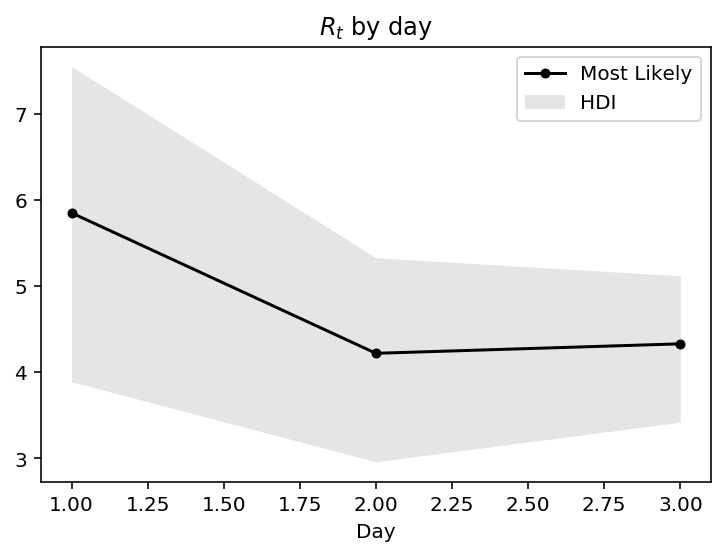

In [9]:
ax = most_likely_values.plot(marker='o',
                             label='Most Likely',
                             title=f'$R_t$ by day',
                             c='k',
                             markersize=4)

ax.fill_between(hdi.index,
                hdi['Low_90'],
                hdi['High_90'],
                color='k',
                alpha=.1,
                lw=0,
                label='HDI')

ax.legend();

Podemos ver que o valor mais provável de $ R_t $ muda com o tempo e o intervalo de maior densidade diminui à medida que nos tornamos mais seguros do valor real de $ R_t $ ao longo do tempo. Observe que, como tínhamos apenas quatro dias de história, não apliquei o processo nesta amostra. A seguir, no entanto, abordaremos um aplicativo do mundo real onde esse processo é necessário.

# Aplicativo do mundo real para dados do Brasil

### Configuração

Baixar os dados dos Estados do Brasil em covid.saude.gov.br

In [15]:
url_ministerio_saude = ('https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/2995b8dbd2134cc15a50d3eef3240b71_Download_COVID19_20200429.csv')
if os.path.exists('DB/ministerio_saude.csv'):
    os.remove('DB/ministerio_saude.csv')
    wget.download(url_ministerio_saude, 'DB/ministerio_saude.csv')
else:
    wget.download(url_ministerio_saude, 'DB/ministerio_saude.csv')

100% [..............................................................................] 80110 / 80110

2.460333851351867


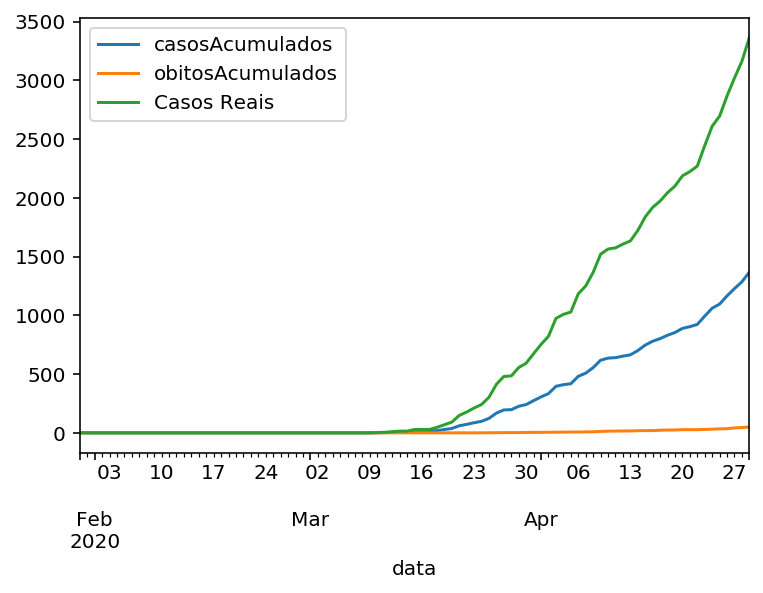

In [16]:
url = 'DB/ministerio_saude.csv'
casos = pd.read_csv(url, sep=';', encoding='cp1252')
casos.columns = ['regiao','sigla','data','casosNovos','casosAcumulados','obitosNovos','obitosAcumulados']
states = pd.read_csv(url,
                     usecols=['data', 'estado', 'casosAcumulados', 'obitosAcumulados'],
                     sep=';',
                     dayfirst=True,
                     parse_dates=['data'],
                     index_col=['estado', 'data'],
                     squeeze=True).sort_index()

DEATH_RATE = 7/100

pd.set_option('mode.use_inf_as_na', True)
deathsBack = states['obitosAcumulados'].shift(-12).mul(1/DEATH_RATE)
casesBack = states['casosAcumulados']

error = (deathsBack/casesBack).mean()
print(error)

realCases = deathsBack.combine(casesBack.mul(error), np.maximum)

S = "RS"
states['casosAcumulados'].xs(S).plot(label='casosAcumulados',
                   legend=True)
states['obitosAcumulados'].xs(S).plot(label='obitosAcumulados',
                   legend=True)
realCases.xs(S).plot(label='Casos Reais',
                   legend=True)

states = realCases


### Analisando o estado, precisamos iniciar a análise quando houver um número consistente de casos por dia. Encontre o último zero dia de caso novo e comece no dia seguinte.

Além disso, o relato de caso é muito irregular, com base em testes de registros em atraso, etc. Para obter a melhor visualização dos dados 'verdadeiros' que pudermos, apliquei um filtro gaussiano nas séries temporais. Esta é obviamente uma escolha arbitrária, mas você imagina que o processo do mundo real não é tão estocástico quanto os relatórios reais.

In [17]:
dados = casos.copy()
dadoslimpo = dados.dropna()
casosNovosDia = dadoslimpo['casosNovos'].groupby(dadoslimpo['data']).sum()
casosNovosDia = casosNovosDia[(casosNovosDia.index >= '2020-02-26')].reset_index()


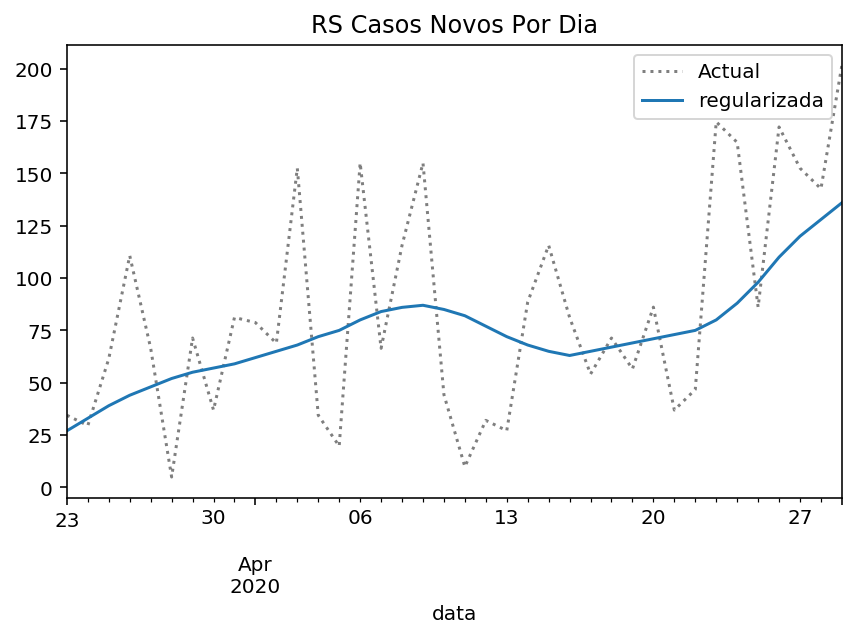

In [18]:
state_name = 'RS'

def prepare_cases(cases, cutoff=25):
    new_cases = cases.diff()

    # CHANGE: rolling average instead of gaussian.
    # CHANGE: not rounded.
    smoothed = new_cases.rolling(7).mean().rolling(7,
        win_type='gaussian',
        center=True,
        min_periods=1).mean(std=2).round()
    
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

original, smoothed = prepare_cases(states.xs(state_name))

original.plot(title=f"{state_name} Casos Novos Por Dia",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 300/72))

ax = smoothed.plot(label='regularizada',
                   legend=True)

ax.get_figure().set_facecolor('w')


### Executando o algoritmo

#### Escolhendo o $ \ sigma $ gaussiano por $ P (R_t | R_ {t-1}) $

> Nota: você pode pular esta seção com segurança se confiar que escolhemos o valor certo de $ \ sigma $ para o processo abaixo. Caso contrário, continue a ler.

A abordagem original simplesmente seleciona o posterior de ontem como o anterior de hoje. Embora intuitivo, isso não permite acreditar que o valor de $ R_t $ provavelmente tenha mudado desde ontem. Para permitir essa alteração, aplicamos ruído gaussiano à distribuição anterior com algum desvio padrão $ \ sigma $. Quanto maior o $ \ sigma $, mais ruído e mais esperaremos que o valor de $ R_t $ seja desviado a cada dia. Curiosamente, aplicar ruído no ruído significa iterativamente que haverá uma deterioração natural dos posteriores distantes. Essa abordagem tem um efeito semelhante de janelas, mas é mais robusta e não esquece arbitrariamente as partes posteriores depois de um certo tempo, como a minha abordagem anterior. Especificamente, a janela calculava um $ R_t $ fixo a cada momento $ t $ que explicava os $ w $ dias de casos circundantes, enquanto a nova abordagem calcula uma série de valores de $ R_t $ que explica todos os casos, assumindo que $ R_t $ flutue por cerca de $ \ sigma $ a cada dia.

No entanto, ainda existe uma escolha arbitrária: o que deveria ser $ \ sigma $? Adam Lerer apontou que podemos usar o processo de máxima probabilidade para informar nossa escolha. Veja como funciona:

A probabilidade máxima diz que gostaríamos de escolher um $ \ sigma $ que maximize a probabilidade de ver nossos dados $ k $: $ P (k | \ sigma) $. Como $ \ sigma $ é um valor fixo, vamos deixar de fora da notação, por isso estamos tentando maximizar $ P (k) $ sobre todas as opções de $ \ sigma $.

Como $ P (k) = P (k_0, k_1, \ ldots, k_t) = P (k_0) P (k_1) \ ldots P (k_t) $, precisamos definir $ P (k_t) $. Acontece que este é o denominador da regra de Bayes:

$$ P (R_t | k_t) = \ frac {P (k_t | R_t) P (R_t)} {P (k_t)} $$

Para calcular, percebemos que o numerador é na verdade apenas a distribuição conjunta de $ k $ e $ R $:

$$ P (k_t, R_t) = P (k_t | R_t) P (R_t) $$

Podemos marginalizar a distribuição acima de $ R_t $ para obter $ P (k_t) $:

$$ P (k_t) = \ sum_ {R_ {t}} {P (k_t | R_t) P (R_t)} $$

Portanto, se somarmos a distribuição do numerador sobre todos os valores de $ R_t $, obteremos $ P (k_t) $. E, como estamos calculando isso de qualquer maneira, como calculamos o posterior, apenas o acompanharemos separadamente.

Como procuramos o valor de $ \ sigma $ que maximize $ P (k) $ no geral, na verdade queremos maximizar:

$$ \ prod_ {t, i} {p (k_ {ti})} $$

onde $ t $ são todos os horários e $ i $ são cada estado.

Como multiplicamos muitas pequenas probabilidades, pode ser mais fácil (e menos propenso a erros) pegar o $ \ log $ dos valores e adicioná-los. Lembre-se de que $ \ log {ab} = \ log {a} + \ log {b} $. E como os logaritmos estão aumentando monotonicamente, maximizar a soma dos $ \ log $ das probabilidades é o mesmo que maximizar o produto das probabilidades não logarítmicas para qualquer opção de $ \ sigma $.

### Função para calcular os posteriores

Para calcular os posteriores, seguimos estas etapas:
1. Calcule $ \ lambda $ - a taxa de chegada esperada para o processo de poisson de cada dia
2. Calcule a distribuição de probabilidade de cada dia sobre todos os valores possíveis de $ R_t $
3. Calcule a matriz do processo com base no valor de $ \ sigma $ que discutimos acima
4. Calcule nossa inicial anterior, porque nosso primeiro dia não possui um dia anterior a partir do qual
  - Com base em [informações do cdc] (https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article), escolheremos um Gamma com média 7.
5. Faça um loop do dia 1 até o final, fazendo o seguinte:
  - Calcule o prior aplicando o gaussiano ao prior de ontem.
  - Aplique a regra de Bayes multiplicando isso antes e a probabilidade calculada na etapa 2.
  - Divida pela probabilidade dos dados (também regra de Bayes)

In [19]:
def get_posteriors(sr, sigma=0.15):
    cols = sr.index

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
                
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        if denominator == 0:
            posteriors[current_day] = 0
            continue
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)

### O resultado


Abaixo você pode ver todos os dias (linha) da distribuição posterior plotados simultaneamente. Os posteriores começam sem muita confiança (ampla) e se tornam progressivamente mais confiantes (mais estreitas) sobre o verdadeiro valor de 𝑅𝑡

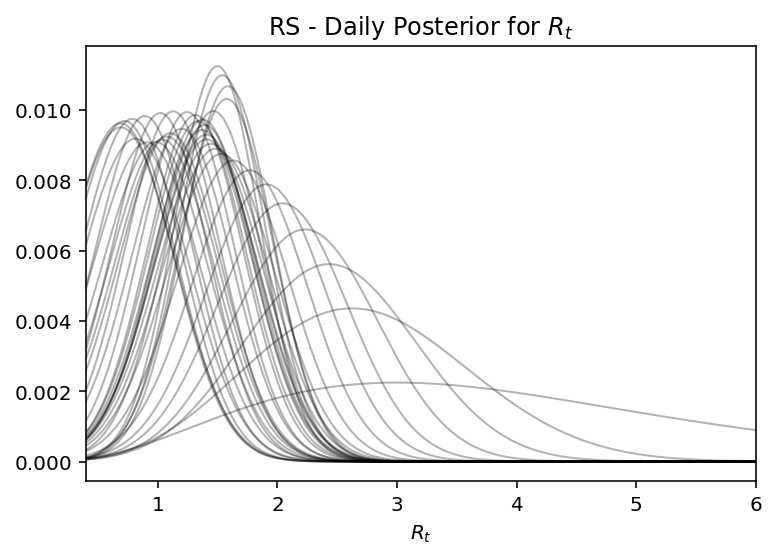

In [20]:
ax = posteriors.plot(title=f'{state_name} - Daily Posterior for $R_t$',
           legend=False, 
           lw=1,
           c='k',
           alpha=.3,
           xlim=(0.4,6))

ax.set_xlabel('$R_t$');

### Plotagem no domínio do tempo com intervalos credíveis

Como nossos resultados incluem incerteza, gostaríamos de poder visualizar o valor mais provável de $ R_t $ junto com o intervalo de maior densidade.

In [21]:
# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()

,ML,Low_90,High_90
data,,,
2020-04-25,1.46,0.78,2.10
2020-04-26,1.58,0.89,2.17
2020-04-27,1.59,0.91,2.15
2020-04-28,1.54,0.90,2.10
2020-04-29,1.50,0.89,2.06


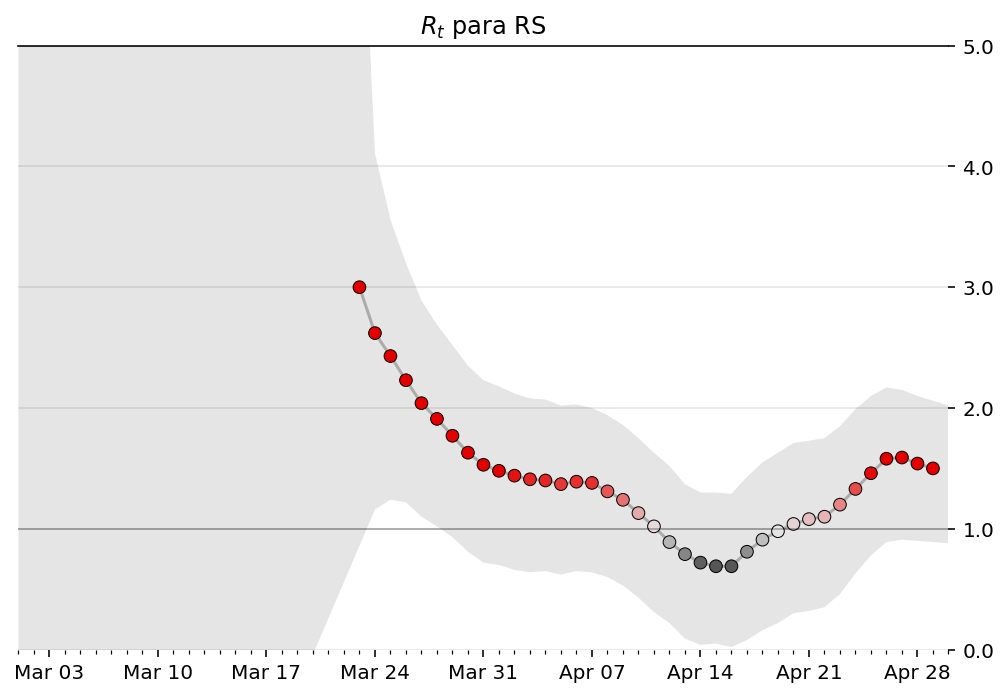

In [22]:
def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name} ")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('data')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('data')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'$R_t$ para {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

### Escolhendo o ideal $\sigma$

Na seção anterior, descrevemos a escolha de um $ \ sigma $ ideal, mas assumimos um valor. Mas agora que podemos avaliar cada estado com qualquer sigma, temos as ferramentas para escolher o $ \ sigma $ ideal.

Acima, dissemos que escolheríamos o valor de $ \ sigma $ que maximiza a probabilidade dos dados $ P (k) $. Como não queremos nos superestimar em nenhum estado, escolhemos o sigma que maximiza $ P (k) $ sobre cada estado. Para fazer isso, somamos todas as probabilidades de log por estado para cada valor de sigma e escolhemos o máximo.

> Nota: isso demora um pouco!

In [26]:
sigmas = np.linspace(1/20, 1, 50)

targets = ~states.index.get_level_values('estado').isin(FILTERED_REGION_CODES)
states_to_process = states.loc[targets]

results = {}

for state_name, cases in states_to_process.groupby(level='estado'):
    print(state_name)
    new, smoothed = prepare_cases(cases, cutoff=25)
    
    if len(smoothed) == 0:
        new, smoothed = prepare_cases(cases, cutoff=5)
        
    # CHANGED: some states in Br have very reported few cases, we ignore those for calculation.
    if len(smoothed) == 0: 
        clear_output(wait=True)
        continue
    
    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    for sigma in sigmas:
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
        result['posteriors'].append(posteriors)
        result['log_likelihoods'].append(log_likelihood)
    
    # Store all results keyed off of state name
    results[state_name] = result
    clear_output(wait=True)

print('Done.')

Done.


Agora que temos todas as probabilidades de log, podemos somar para cada valor de sigma entre estados, representar graficamente e escolher o valor máximo

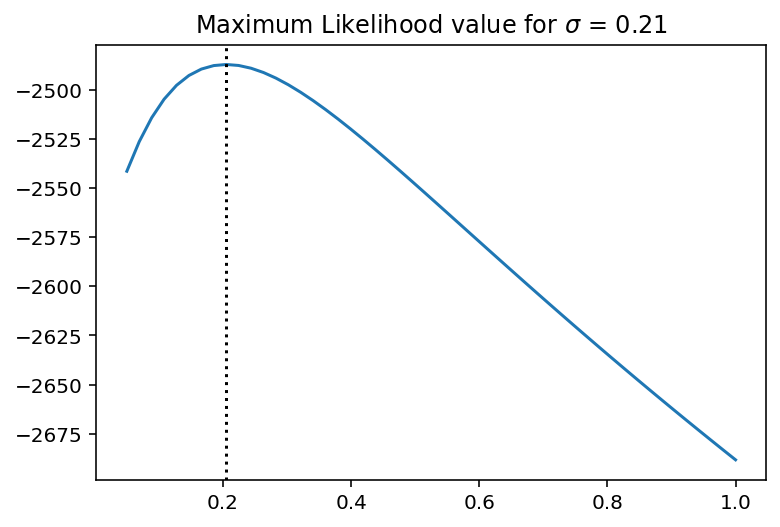

In [27]:
# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for state_name, result in results.items():
    if states.xs(state_name)[-1] < 500: continue
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

# Plot it
fig, ax = plt.subplots()
ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")

### Compilar resultados finais

Dado que selecionamos o $ \ sigma $ ideal, vamos pegar o posterior pré-calculado correspondente ao valor de $ \ sigma $ para cada estado. Vamos também calcular os intervalos de densidade mais altos de 90% e 50% (isso leva um tempo) e também o valor mais provável.

In [28]:
final_results = None

for state_name, result in results.items():
    if state_name in FILTERED_REGION_CODES: continue
    print(state_name)
    posteriors = result['posteriors'][max_likelihood_index]
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    most_likely = posteriors.idxmax().rename('ML')
    result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
    if final_results is None:
        final_results = result
    else:
        final_results = pd.concat([final_results, result])
    clear_output(wait=True)

print('Done.')

Done.


### Plotar todos os estados da BR

$R_t$ é a taxa de transmissão do vírus no tempo. O número representa, dado uma infecção por Covid-19, qual o número de novas pessoas que serão na média infectadas. Se $R_t$ = 1, o número de infectados permanece constante no tempo (cada infectado infecta mais uma pessoa). Se $R_t$ > 1, o vírus está em crescimento exponencial.

As medidas de isolamento existem para manter $R_t$ baixo. Um número $R_t$ < 1 significa que as medidas estão funcionando.


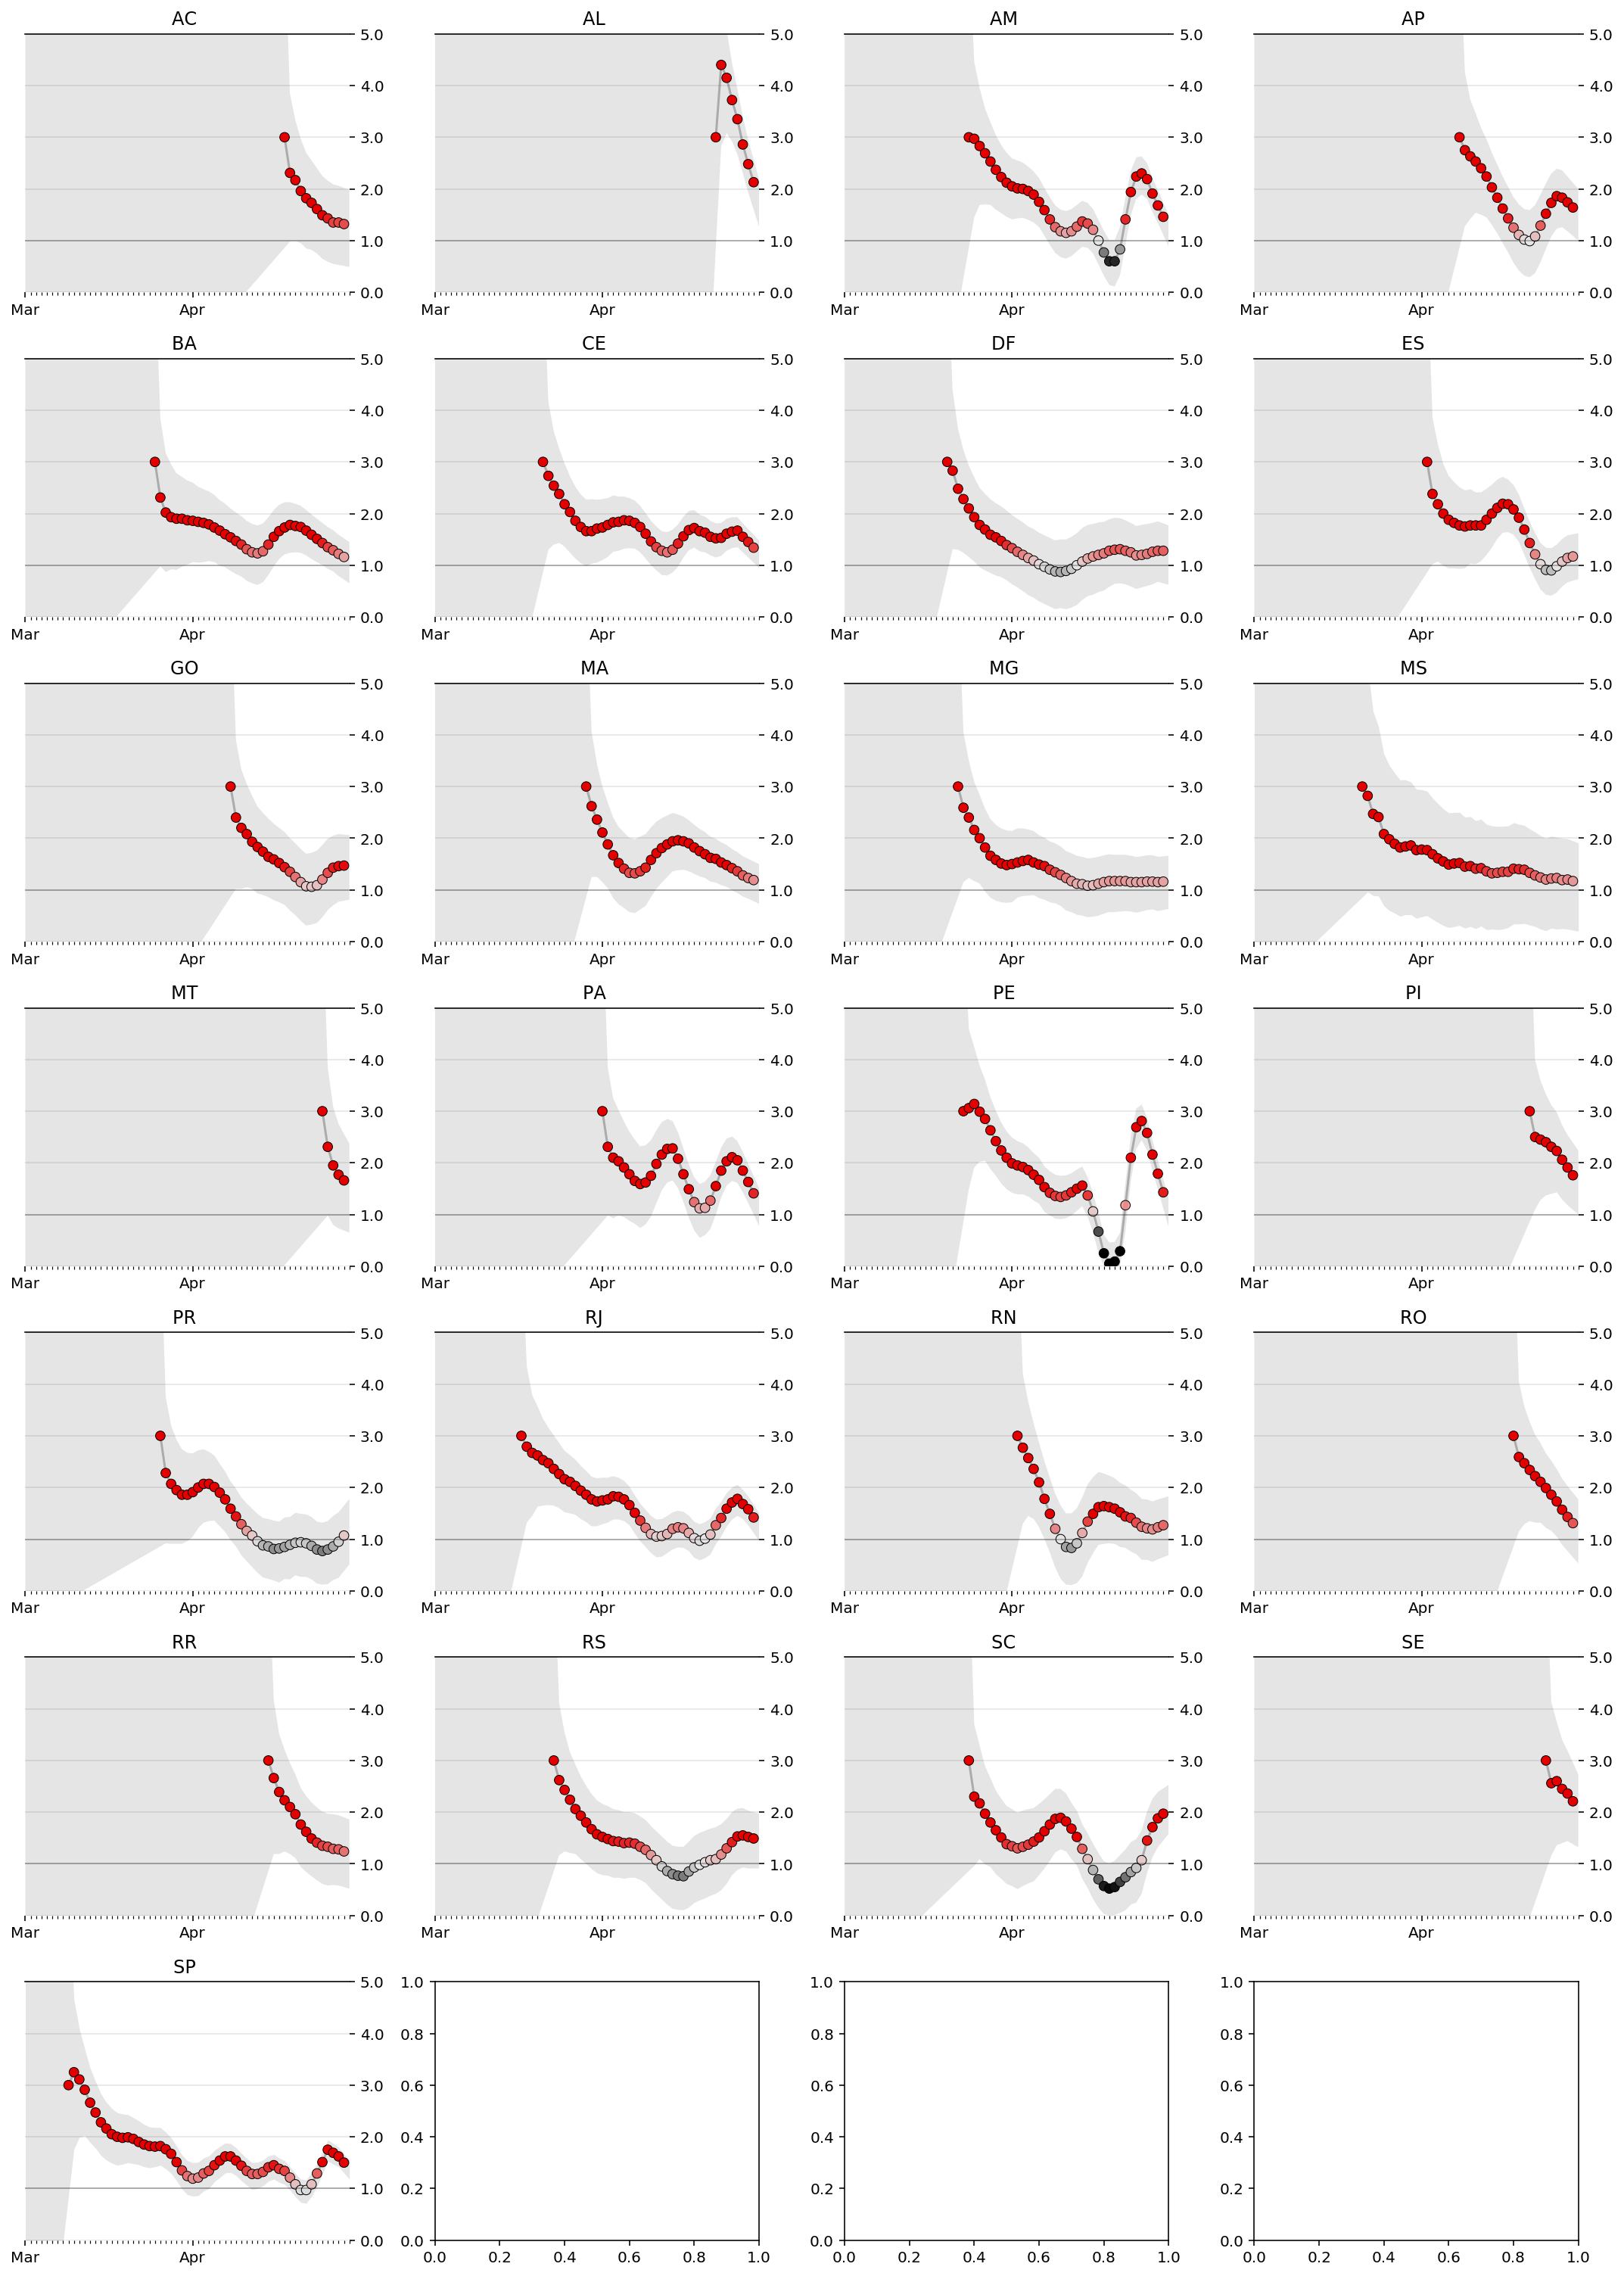

In [29]:
ncols = 4
nrows = int(np.ceil(len(results) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(final_results.groupby('estado')):
    if result.shape[0] < 2: continue
    plot_rt(result, axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor('w')

### Export Data to CSV

In [30]:
# Uncomment the following line if you'd like to export the data
final_results.to_csv('DB/rt.csv')

### Standings

In [31]:
# As of 4/12
no_lockdown = [
]
partial_lockdown = [
]

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]

In [32]:
final_results

ML  Low_90  High_90  Low_50  High_50
estado data                                              
AC     2020-04-18  3.00    0.86     6.84    1.86     4.27
       2020-04-19  2.31    0.98     3.84    1.71     2.91
       2020-04-20  2.17    0.99     3.33    1.67     2.64
       2020-04-21  1.96    0.95     2.97    1.47     2.31
       2020-04-22  1.82    0.85     2.70    1.40     2.16
...                 ...     ...      ...     ...      ...
SP     2020-04-25  1.51    1.28     1.71    1.39     1.57
       2020-04-26  1.75    1.53     1.94    1.64     1.81
       2020-04-27  1.69    1.47     1.87    1.57     1.74
       2020-04-28  1.62    1.42     1.80    1.51     1.67
       2020-04-29  1.50    1.30     1.67    1.38     1.54

[705 rows x 5 columns]

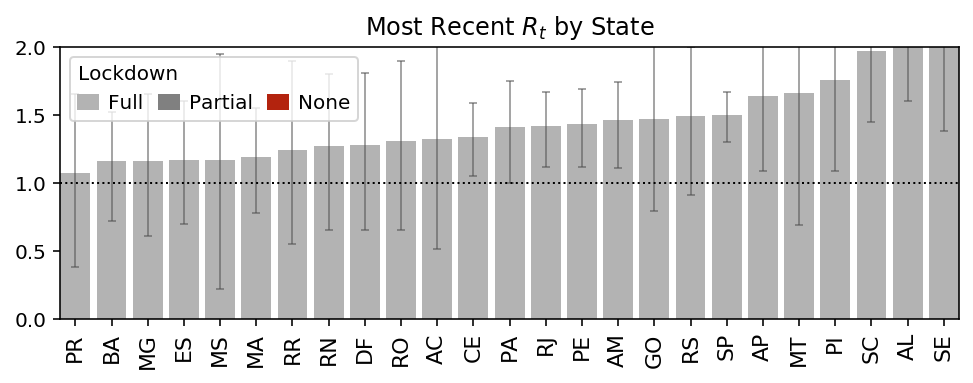

In [34]:
filtered = final_results.index.get_level_values(0).isin(FILTERED_REGION_CODES)
mr = final_results.loc[~filtered].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in no_lockdown:
            bar.set_color(NONE_COLOR)
        if state_name in partial_lockdown:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series().replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='Full', color=FULL_COLOR),
                        Patch(label='Partial', color=PARTIAL_COLOR),
                        Patch(label='None', color=NONE_COLOR)
                    ],
                    title='Lockdown',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

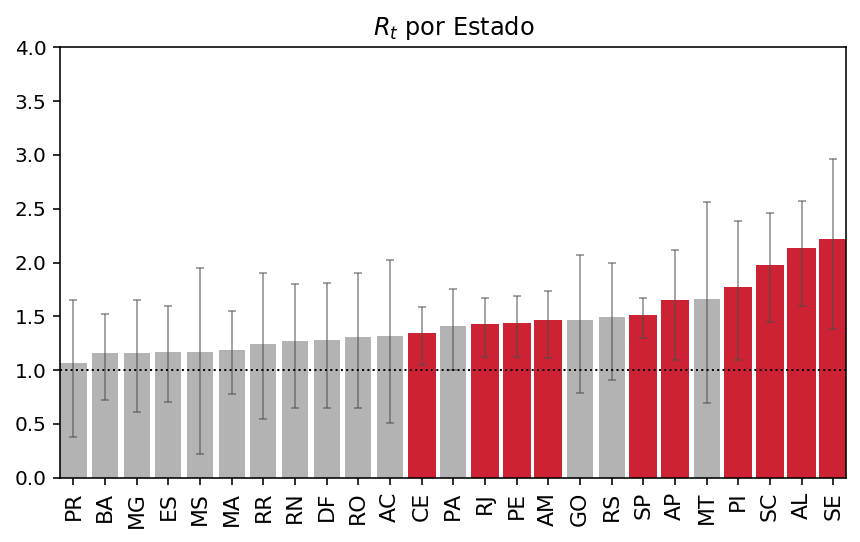

In [35]:
filtered = final_results.index.get_level_values(0).isin(final_results)
mr = final_results.loc[~filtered].groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

# 507x285
def plot_standings(mr, figsize=None, title='$R_t$ por Estado'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if mr['Low_90'][state_name] > 1:
            bar.set_color("#cc2233")
        if mr['High_90'][state_name] < 1:
            bar.set_color("#009900")

    labels = mr.index.to_series()
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,4.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
fig, ax = plot_standings(mr, (507/72, 285/72))
fig.savefig("IMG/perstate.png")

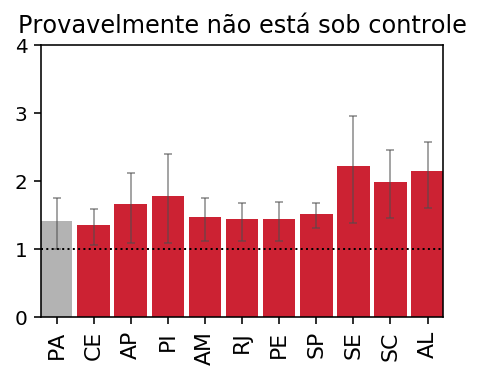

In [49]:
show = mr[mr.Low_90.ge(1.0)].sort_values('Low_90')
fig, ax = plot_standings(show, title='Provavelmente não está sob controle');
ax.get_legend()

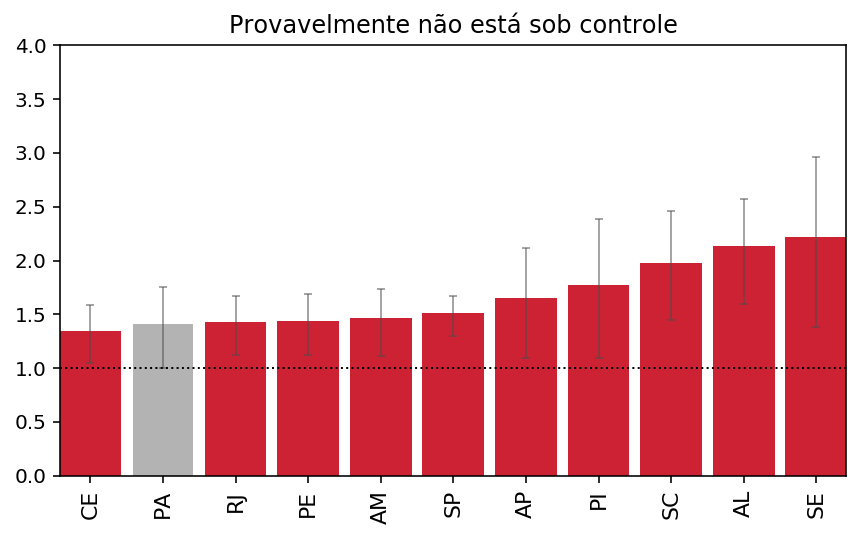

In [65]:
show = mr[mr.Low_90.ge(1.0)].sort_values('ML')
fig, ax = plot_standings(show, title='Provavelmente não está sob controle',figsize=(507/72, 285/72));
ax.get_legend()

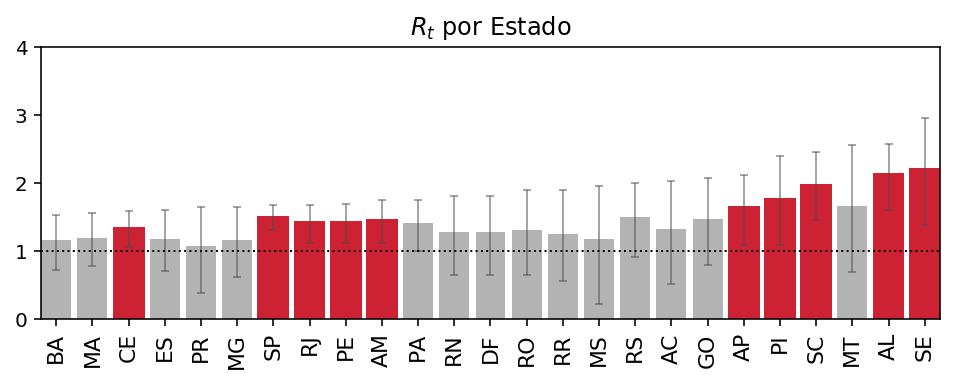

In [39]:
mr.sort_values('High_90', inplace=True)
plot_standings(mr);

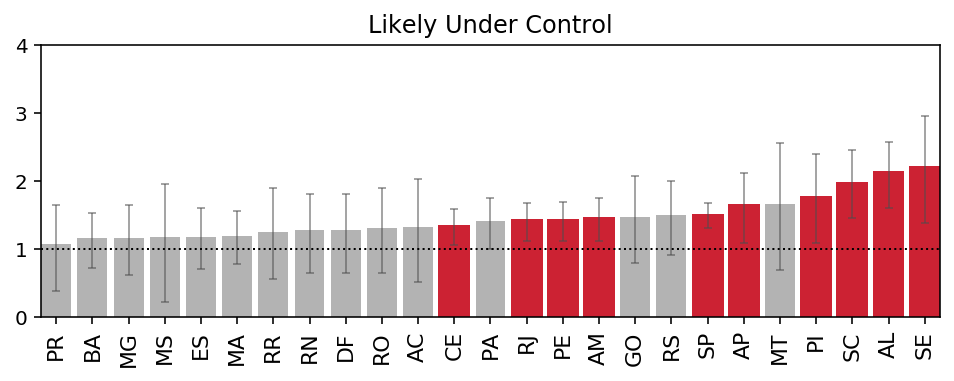

In [62]:
show = mr[mr.High_90.le(10)].sort_values('ML')
fig, ax = plot_standings(show, title='Likely Under Control');

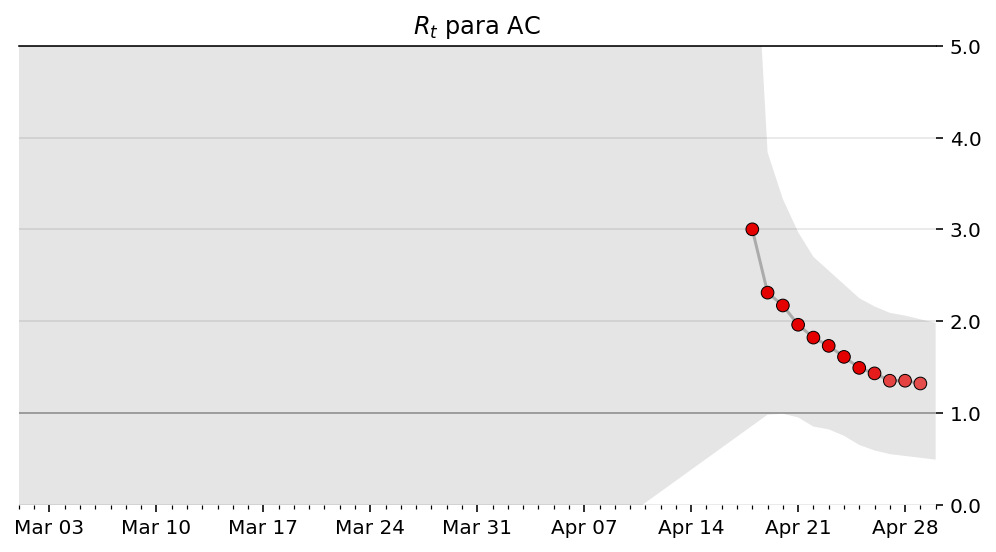

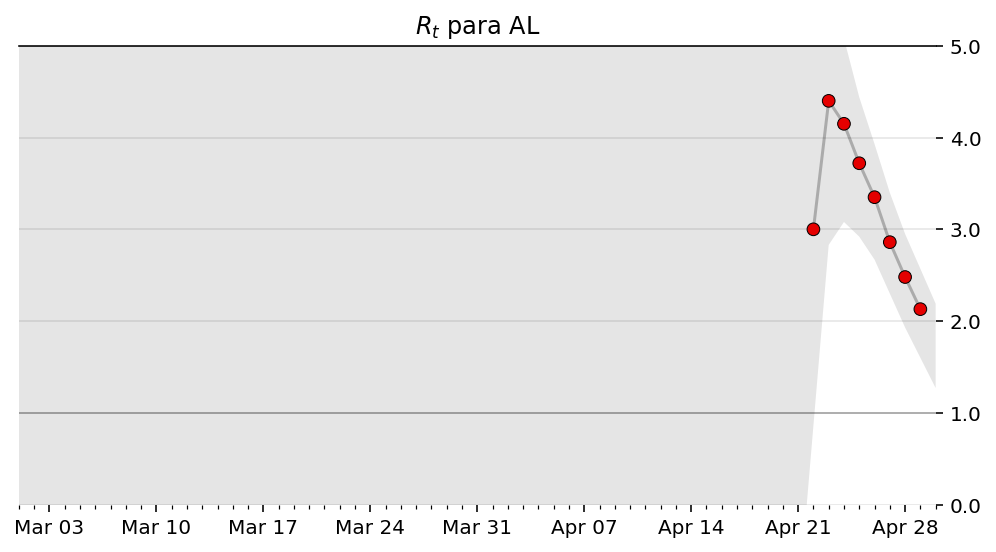

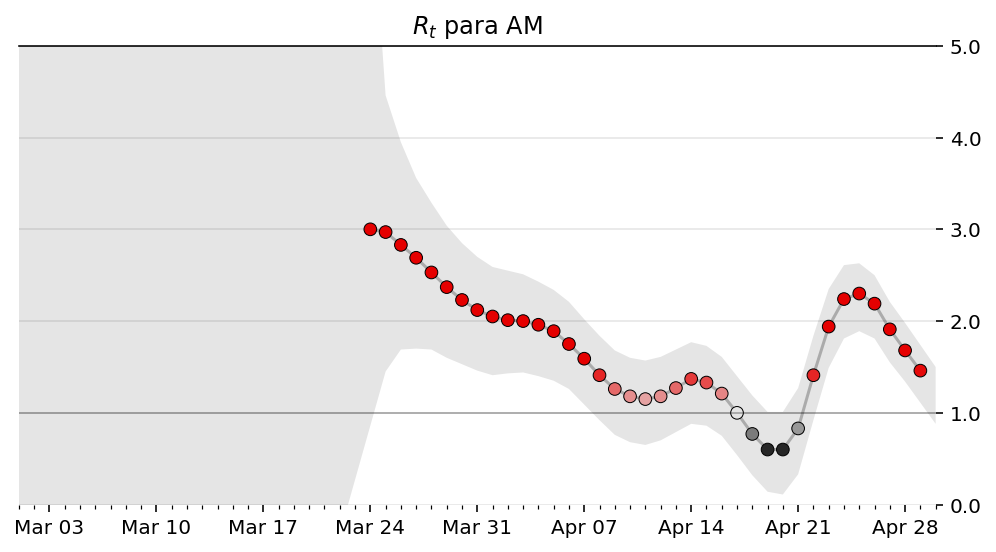

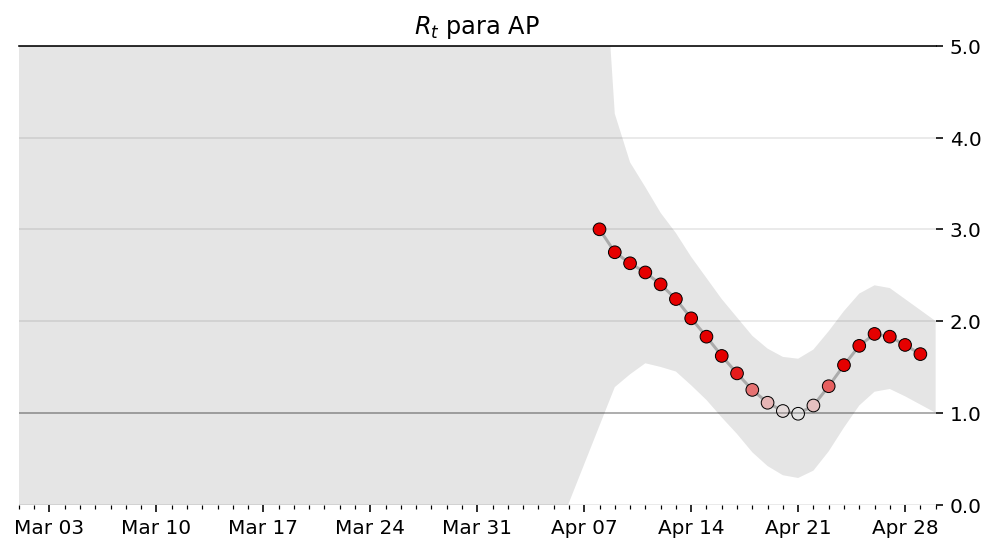

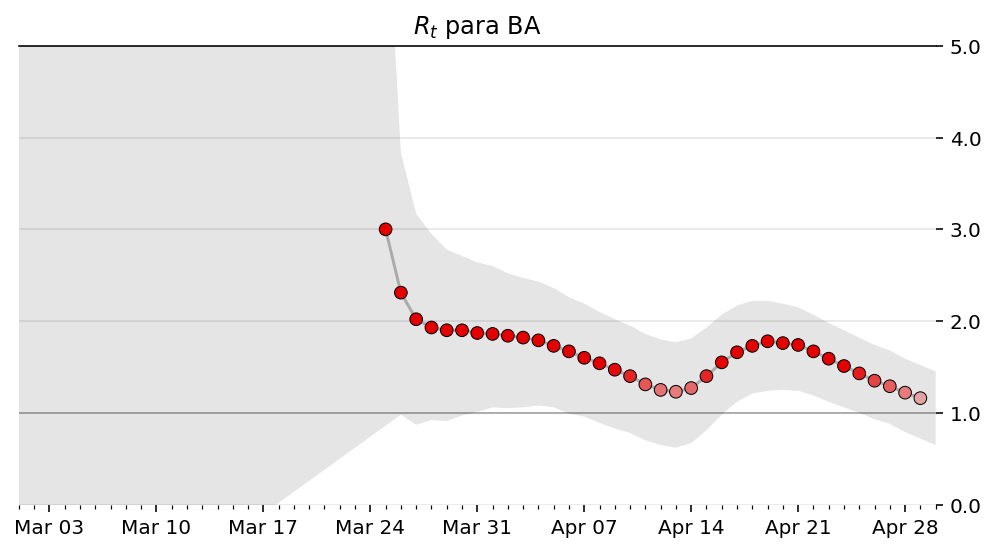

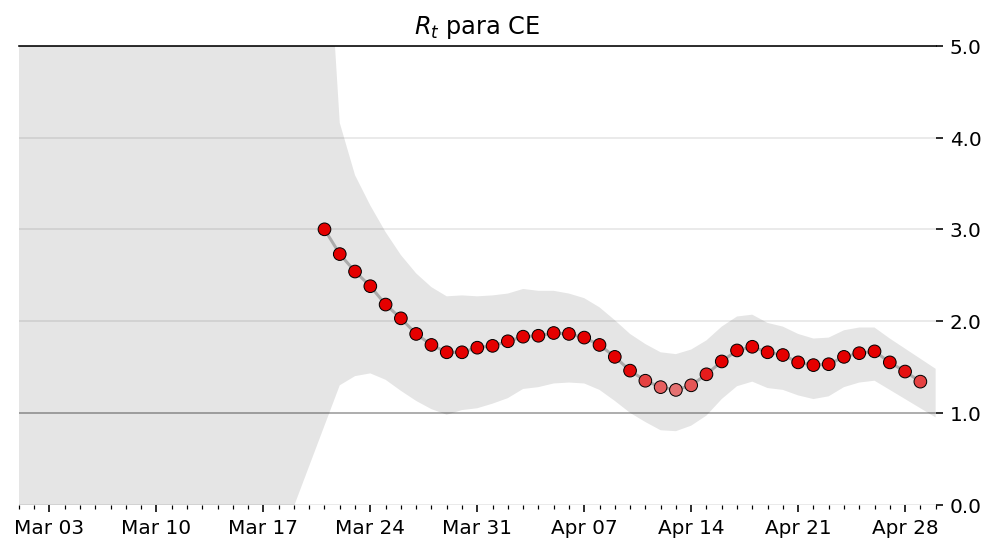

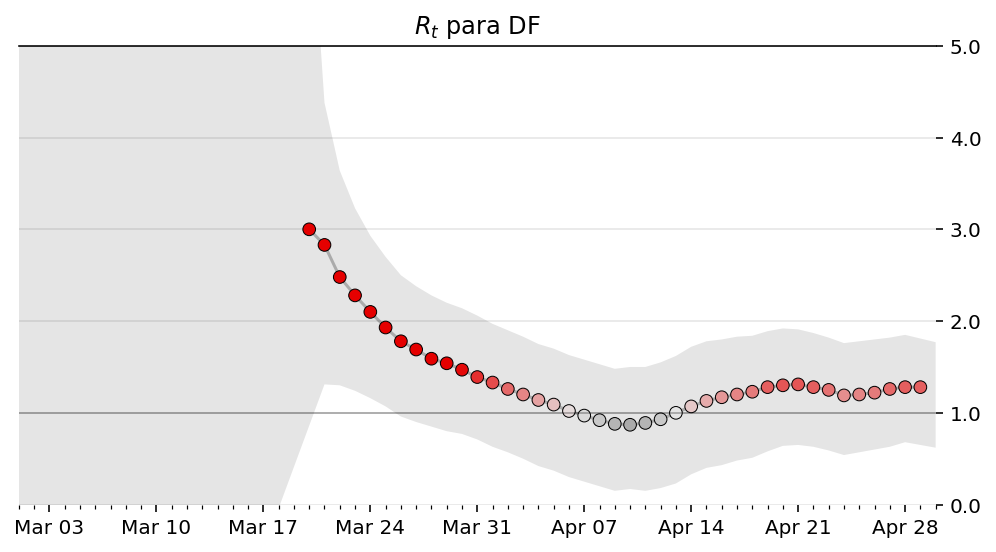

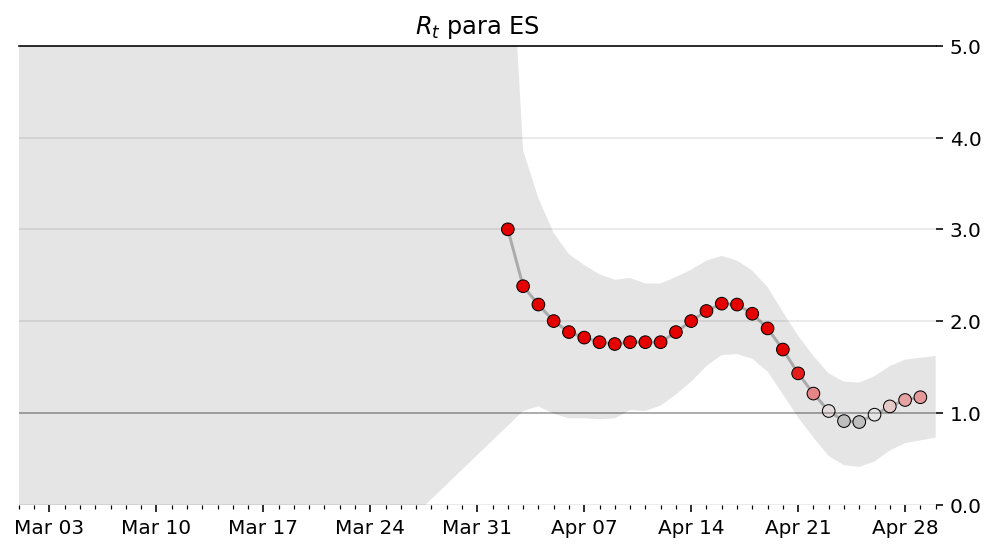

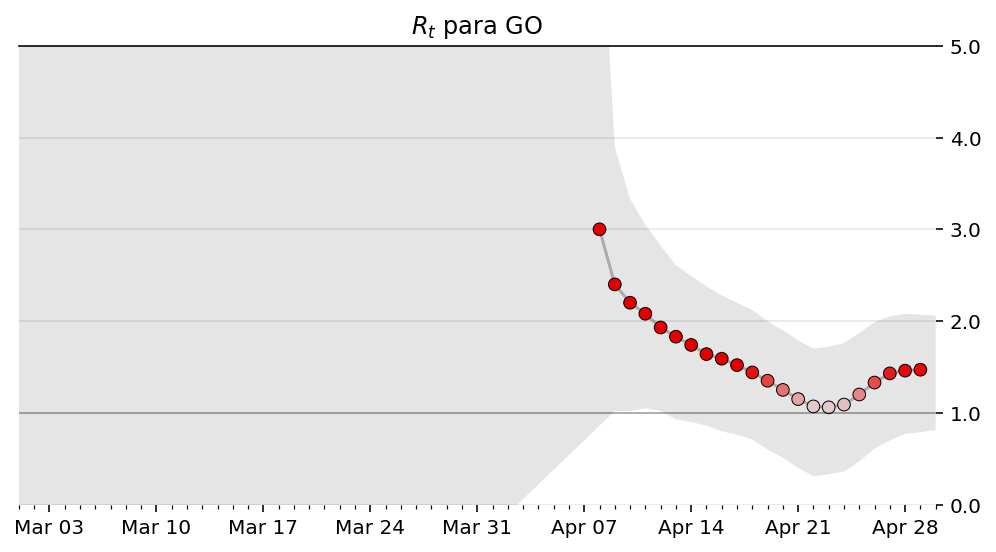

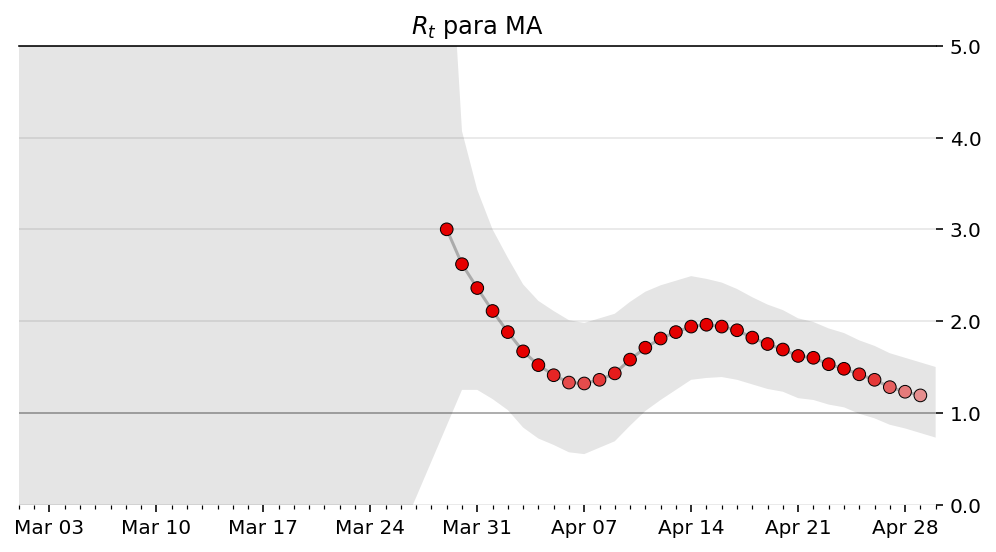

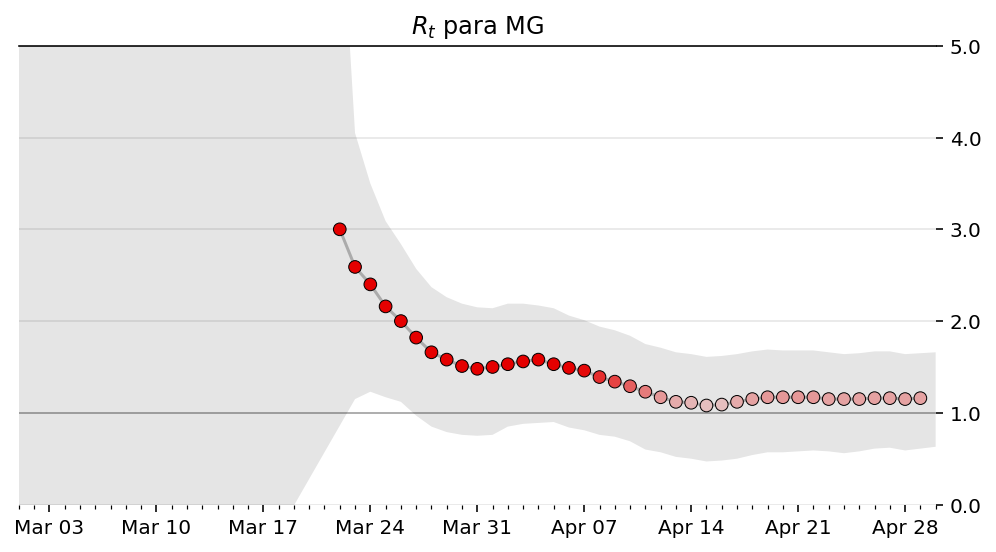

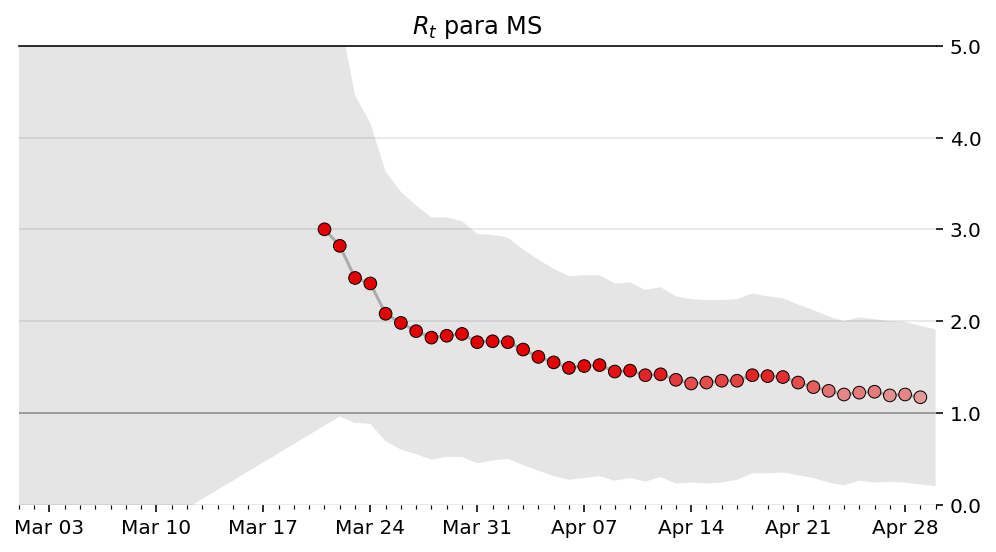

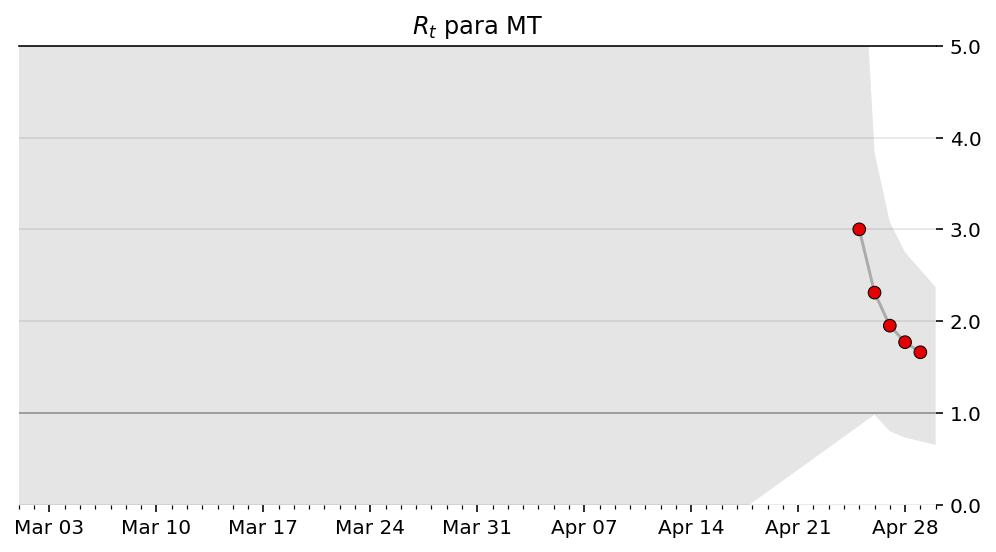

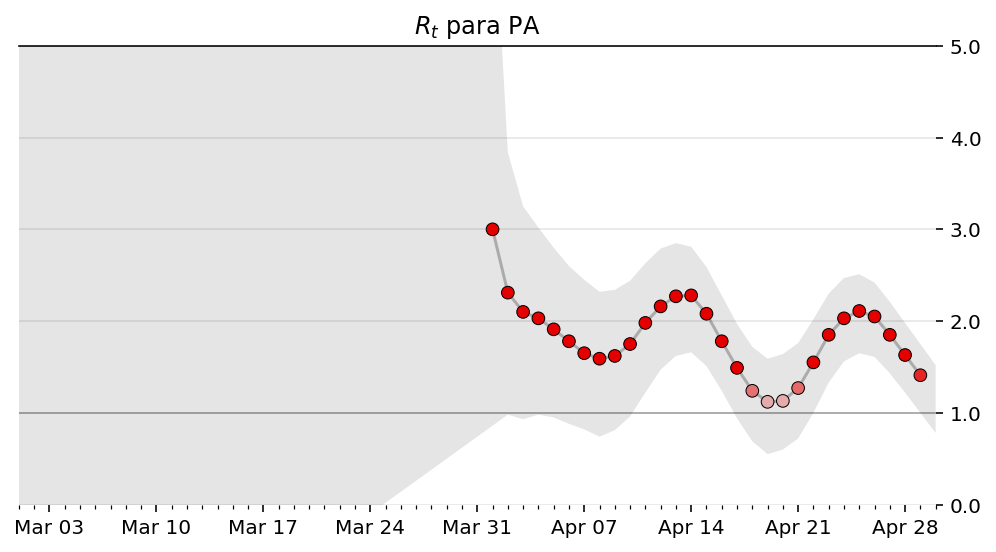

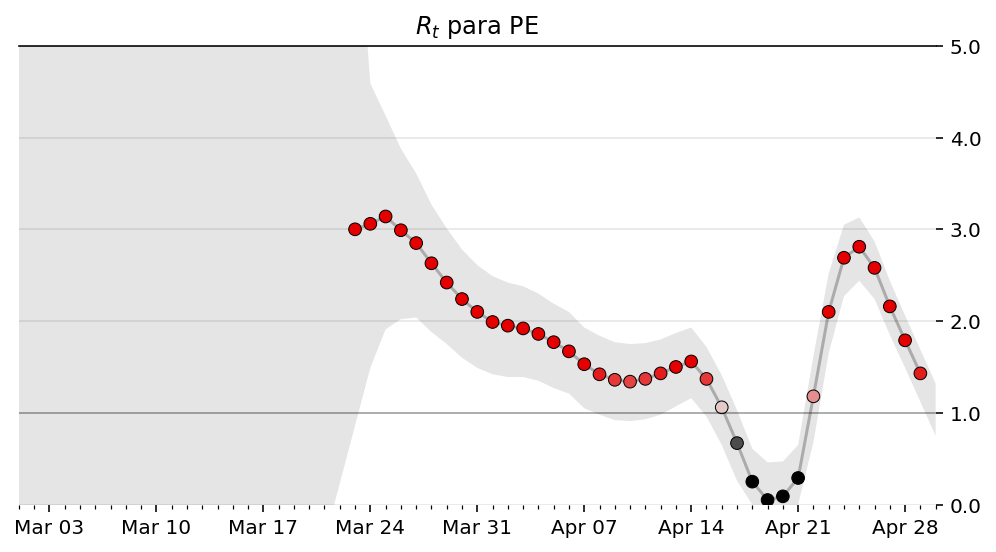

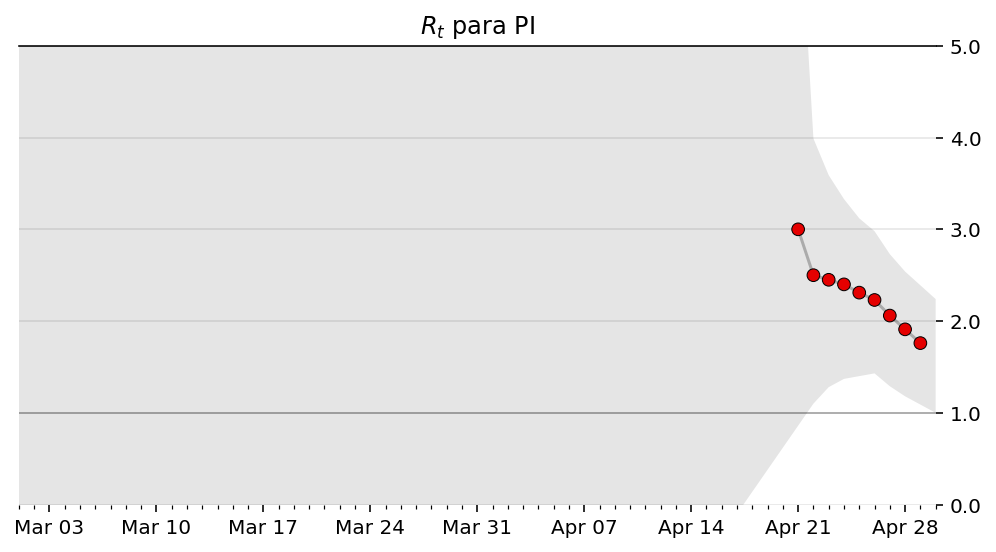

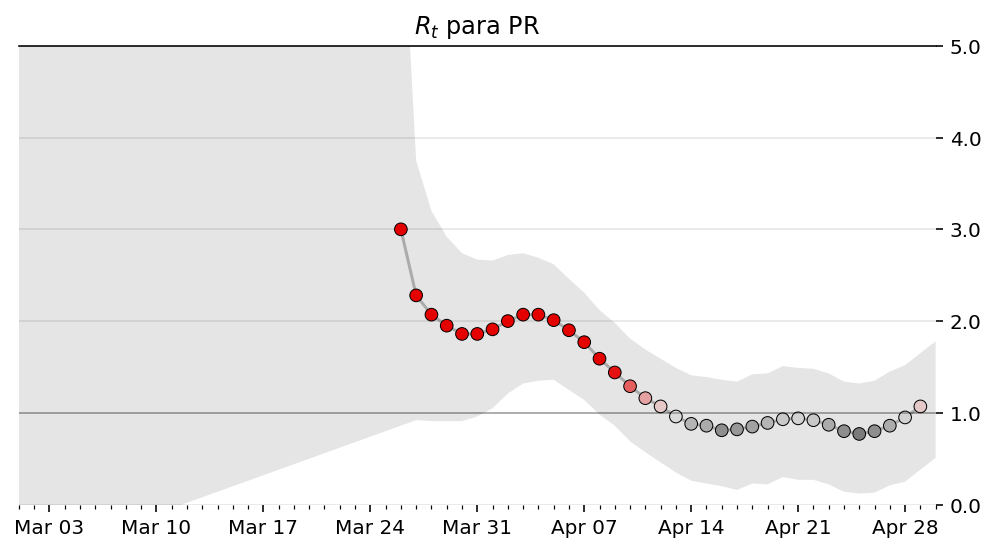

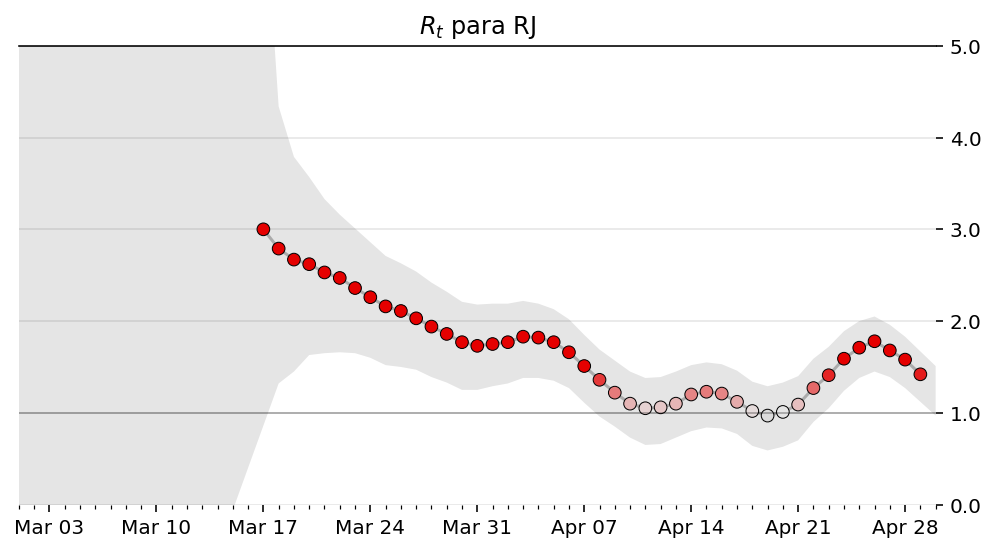

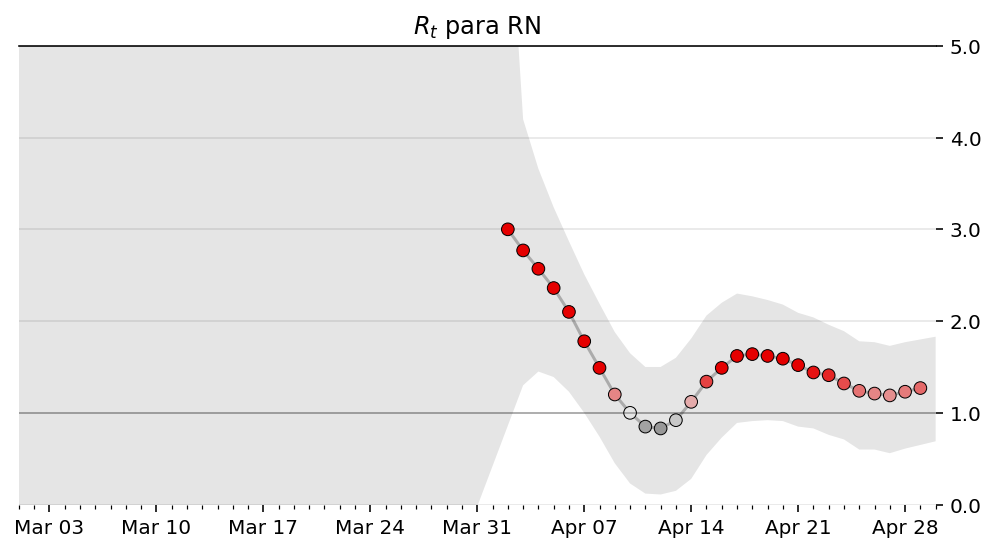

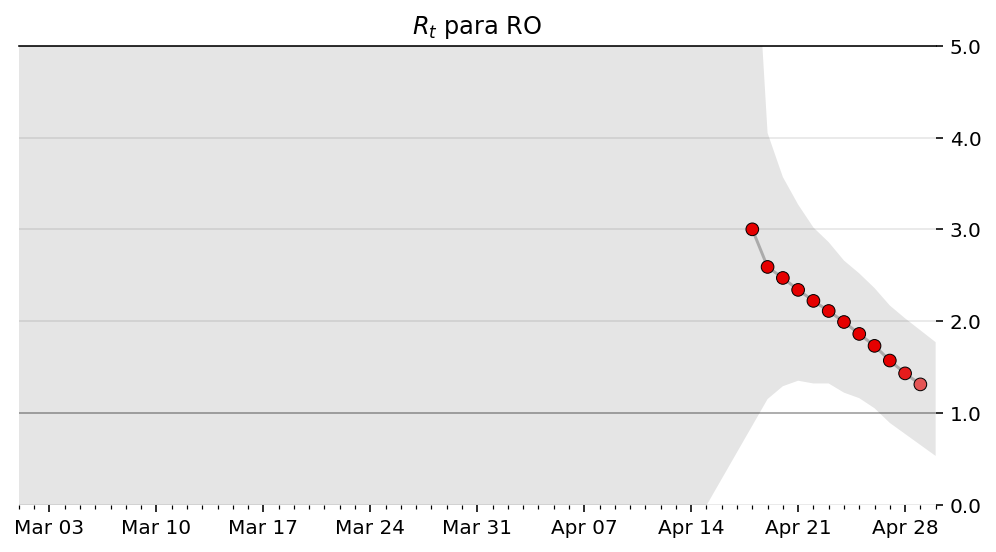

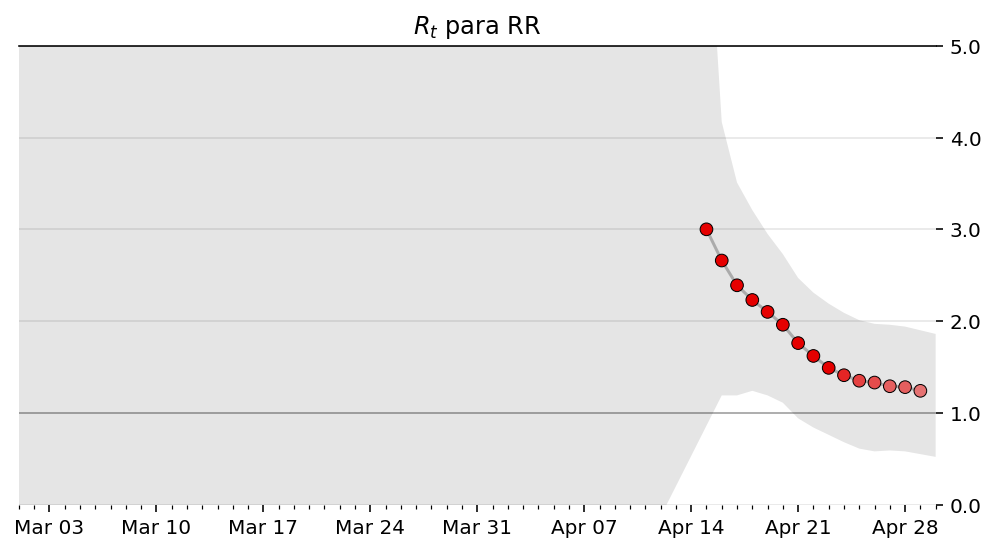

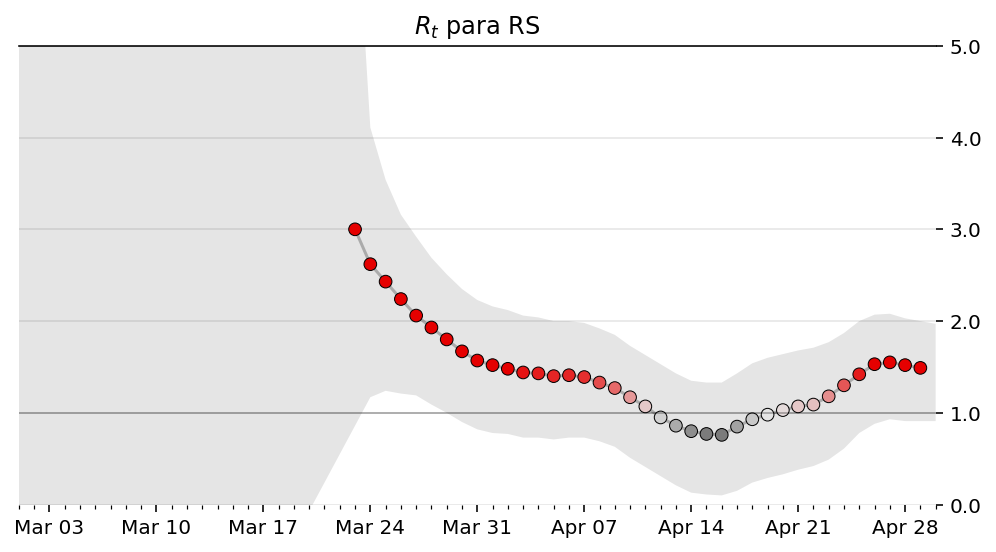

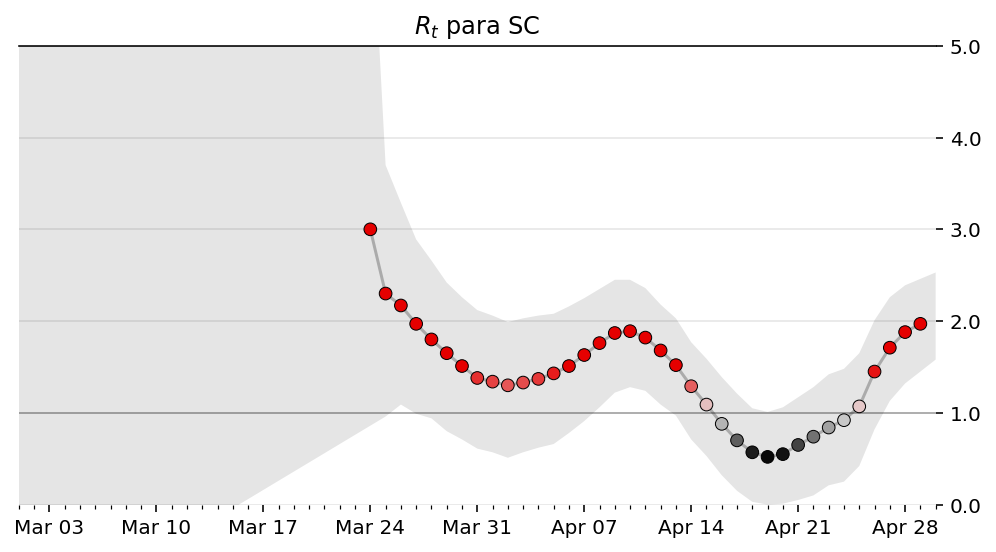

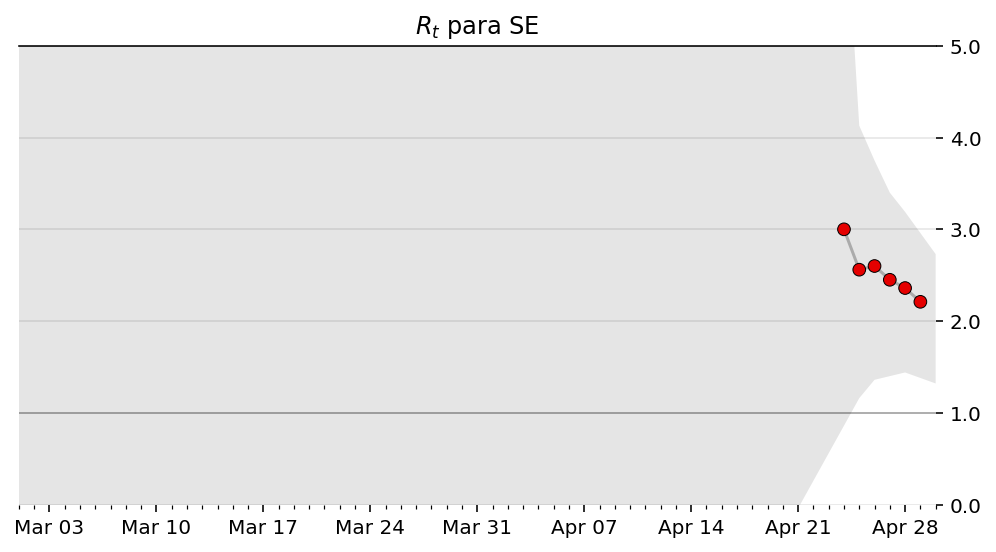

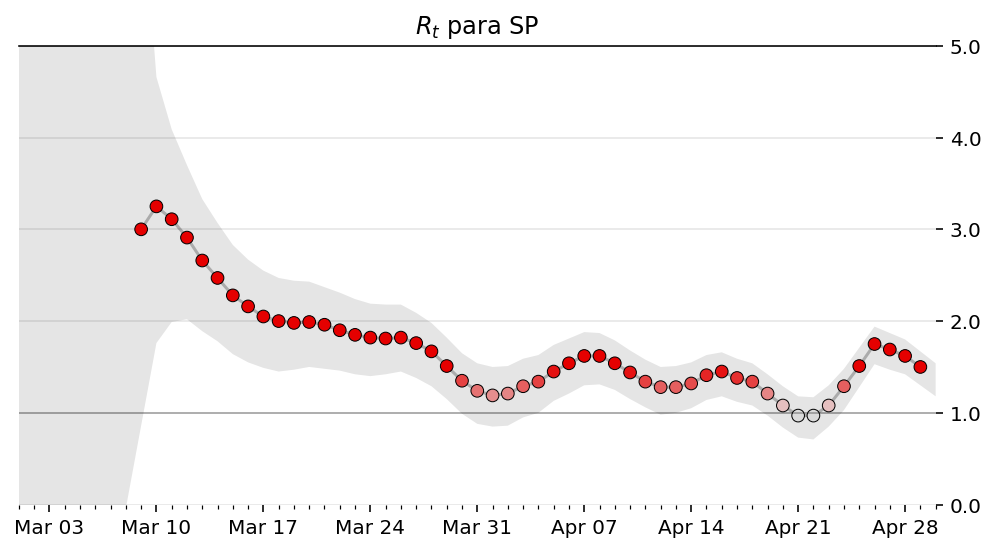

In [36]:

for i, (state_name, result) in enumerate(final_results.groupby('estado')):
    fig, ax = plt.subplots(figsize=(507/72, 285/72))
    plot_rt(result, ax, state_name)
    ax.set_title(f'$R_t$ para {state_name}')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))    
    fig.tight_layout()
    fig.set_facecolor('w')
    fig.savefig(f"IMG/{state_name}.png")